In [1]:
!nvidia-smi

Tue Mar  8 18:53:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:09:00.0  On |                  N/A |
|  0%   49C    P8    22W / 175W |   1076MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
cd /content/drive/MyDrive

/content/drive/MyDrive


# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

#Fix for same result
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2) 

print('Libraries Loaded')

Libraries Loaded


# Utilities

In [3]:
def read_file(path):
    '''
    Returns the dataframe which is read from the excel file present in the path specified. 
    
    Parameters:
        path (str) : The path of the file
    
    Returns:
        df (float) : The dataframe which is created after reading the file.
    '''
    df= pd.read_csv(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    '''
    Returns the prepared data based on the lag and look ahead
    
    Parameters:
        X          (float): The independent variables of the data
        y          (float): The dependent variables of the data
        time_steps (int)  : The lag that is being used to lookback
        ts_range   (int)  : The lookahead for the data
    
    Returns:
        Xs (float) : The numpy array of the input variable
        ys (float) : The numpy array of the output variable 
    '''
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    '''
    Returns the training and testing data
    
    Parameters:
        df (float): The whole dataframe containing the independent and dependent variables
        output(str): The output variable 
        lag (int): The lag that needs to be applied for the data
        duration (int): The duration that is being considered as output
        ts (float): The percentage of training data
    
    Returns:
        x_train (float): The training data of independent variable 
        x_test (float): The testing data of independent variable
        y_train (float): The training data of the depenedent variable 
        y_test (float): The testing data of the dependent variable 
    '''
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    Attention layer for the neural networks.
    
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being inspired from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

# Data Preparation

In [4]:
## Specifying the source path
filename_upstream = r'oldderry.csv'
filename_downstream = r'MGCC.csv'


## Specifying the destination path
#dest = r''

## Reading the file
df_up = read_file(filename_upstream)
df_down = read_file(filename_downstream)

##Dropping the columns that are not needed such as Discharge, since all the values are NaN
df_down.drop(columns=['Discharge'], inplace=True)

(39845, 8)
         Time Hour  Air Temp  Water Temp  Chloride Concentration  \
0  2012/4/19 15:00   20.2150     10.6650                 97.0900   
1  2012/4/19 16:00   20.5575     11.4225                 95.8975   
2  2012/4/19 17:00   23.3150     12.3825                 93.8325   
3  2012/4/19 18:00   23.3275     13.3350                 93.6525   
4  2012/4/19 19:00   24.3900     14.0200                 93.8050   

   Dissolved Oxygen     pH  Specific Conductivity  Turbidity  
0           11.3000  8.500                  740.0      3.500  
1           11.4525  8.500                  730.0      2.900  
2           11.5250  8.500                  725.0      3.100  
3           11.4000  8.575                  720.0      3.500  
4           11.2200  8.600                  720.0      3.425  
(39845, 9)
         Time Hour  Air Temp  Water Temp  Chloride Concentration     pH  \
0  2012/4/19 15:00   13.3700     11.8050                 111.950  8.300   
1  2012/4/19 16:00   15.1125     12.6925 

In [5]:
df_up.head()

,Time Hour,Air Temp,Water Temp,Chloride Concentration,Dissolved Oxygen,pH,Specific Conductivity,Turbidity
0,2012/4/19 15:00,20.2150,10.6650,97.0900,11.3000,8.500,740.0,3.500
1,2012/4/19 16:00,20.5575,11.4225,95.8975,11.4525,8.500,730.0,2.900
2,2012/4/19 17:00,23.3150,12.3825,93.8325,11.5250,8.500,725.0,3.100
3,2012/4/19 18:00,23.3275,13.3350,93.6525,11.4000,8.575,720.0,3.500
4,2012/4/19 19:00,24.3900,14.0200,93.8050,11.2200,8.600,720.0,3.425


In [6]:
df_down.head()

,Time Hour,Air Temp,Water Temp,Chloride Concentration,pH,Specific Conductivity,Turbidity,Dissolved Oxygen
0,2012/4/19 15:00,13.3700,11.8050,111.950,8.300,840.0,2.250,11.7350
1,2012/4/19 16:00,15.1125,12.6925,113.500,8.375,840.0,1.500,11.7275
2,2012/4/19 17:00,15.2275,13.8375,116.525,8.400,840.0,1.650,11.4825
3,2012/4/19 18:00,17.7450,14.6900,118.175,8.400,840.0,1.225,11.1100
4,2012/4/19 19:00,19.3625,15.7975,120.775,8.400,840.0,1.150,10.9625


In [7]:
# Splitting the Time Hour column into year,month,date, hour columns
year_values = []
month_values = []
date_values = []
time_values = []

for i in df_up['Time Hour']:
    year, month, date_time = i.split('/')
    date, time = date_time.split(' ')
    time = time[:-3]
    year_values.append(year)
    month_values.append(month)
    date_values.append(date)
    time_values.append(time)

In [8]:
# adding the new column and dropping the old Time Hour column in df dataFrame
df_up['Year'] = year_values
df_up['Month'] = month_values
df_up['Date'] = date_values
df_up['Time'] = time_values
# dropping "Time Hour" column
df_up.drop(columns=['Time Hour'], inplace=True)
df_up.head()

,Air Temp,Water Temp,Chloride Concentration,Dissolved Oxygen,pH,Specific Conductivity,Turbidity,Year,Month,Date,Time
0,20.2150,10.6650,97.0900,11.3000,8.500,740.0,3.500,2012,4,19,15
1,20.5575,11.4225,95.8975,11.4525,8.500,730.0,2.900,2012,4,19,16
2,23.3150,12.3825,93.8325,11.5250,8.500,725.0,3.100,2012,4,19,17
3,23.3275,13.3350,93.6525,11.4000,8.575,720.0,3.500,2012,4,19,18
4,24.3900,14.0200,93.8050,11.2200,8.600,720.0,3.425,2012,4,19,19


In [9]:
# adding the new column and dropping the old Time Hour column in df dataFrame
df_down['Year'] = year_values
df_down['Month'] = month_values
df_down['Date'] = date_values
df_down['Time'] = time_values
# dropping "Time Hour" column
df_down.drop(columns=['Time Hour'], inplace=True)
df_down.head()

,Air Temp,Water Temp,Chloride Concentration,pH,Specific Conductivity,Turbidity,Dissolved Oxygen,Year,Month,Date,Time
0,13.3700,11.8050,111.950,8.300,840.0,2.250,11.7350,2012,4,19,15
1,15.1125,12.6925,113.500,8.375,840.0,1.500,11.7275,2012,4,19,16
2,15.2275,13.8375,116.525,8.400,840.0,1.650,11.4825,2012,4,19,17
3,17.7450,14.6900,118.175,8.400,840.0,1.225,11.1100,2012,4,19,18
4,19.3625,15.7975,120.775,8.400,840.0,1.150,10.9625,2012,4,19,19


In [10]:
df_up.rename(columns={"Air Temp": "Air_Temp_Up", "Water Temp": "Water_Temp_Up", "Chloride Concentration": "Chloride_Up", "pH": "pH_Up", "Specific Conductivity": "Cond_Up", "Turbidity": "Turbidity_Up", "Dissolved Oxygen": "DO_Up",}, inplace=True)

In [11]:
df_down.rename(columns={"Air Temp": "Air_Temp_Dn", "Water Temp": "Water_Temp_Dn", "Chloride Concentration": "Chloride_Dn", "pH": "pH_Dn", "Specific Conductivity": "Cond_Dn", "Turbidity": "Turbidity_Dn", "Dissolved Oxygen": "DO_Dn",}, inplace=True)

In [12]:
df_up.head()

,Air_Temp_Up,Water_Temp_Up,Chloride_Up,DO_Up,pH_Up,Cond_Up,Turbidity_Up,Year,Month,Date,Time
0,20.2150,10.6650,97.0900,11.3000,8.500,740.0,3.500,2012,4,19,15
1,20.5575,11.4225,95.8975,11.4525,8.500,730.0,2.900,2012,4,19,16
2,23.3150,12.3825,93.8325,11.5250,8.500,725.0,3.100,2012,4,19,17
3,23.3275,13.3350,93.6525,11.4000,8.575,720.0,3.500,2012,4,19,18
4,24.3900,14.0200,93.8050,11.2200,8.600,720.0,3.425,2012,4,19,19


In [13]:
df_down.head()

,Air_Temp_Dn,Water_Temp_Dn,Chloride_Dn,pH_Dn,Cond_Dn,Turbidity_Dn,DO_Dn,Year,Month,Date,Time
0,13.3700,11.8050,111.950,8.300,840.0,2.250,11.7350,2012,4,19,15
1,15.1125,12.6925,113.500,8.375,840.0,1.500,11.7275,2012,4,19,16
2,15.2275,13.8375,116.525,8.400,840.0,1.650,11.4825,2012,4,19,17
3,17.7450,14.6900,118.175,8.400,840.0,1.225,11.1100,2012,4,19,18
4,19.3625,15.7975,120.775,8.400,840.0,1.150,10.9625,2012,4,19,19


In [14]:
# change this feature combination list to do different combination of feature testing
# we add both upstream and downstream data to increase feature data
feature_combination_up = ['Air_Temp_Up', 'Water_Temp_Up', 'Chloride_Up','pH_Up','Cond_Up','Turbidity_Up', 'DO_Up']
feature_combination_down = ['Air_Temp_Dn', 'Water_Temp_Dn', 'Chloride_Dn','pH_Dn','Cond_Dn','Turbidity_Dn']
target_column = ['DO_Dn']

In [15]:
df_total_set = pd.concat([df_up[feature_combination_up], df_down[feature_combination_down], df_down[target_column]], axis=1)

In [16]:
df_total_set.head()

,Air_Temp_Up,Water_Temp_Up,Chloride_Up,pH_Up,Cond_Up,Turbidity_Up,DO_Up,Air_Temp_Dn,Water_Temp_Dn,Chloride_Dn,pH_Dn,Cond_Dn,Turbidity_Dn,DO_Dn
0,20.2150,10.6650,97.0900,8.500,740.0,3.500,11.3000,13.3700,11.8050,111.950,8.300,840.0,2.250,11.7350
1,20.5575,11.4225,95.8975,8.500,730.0,2.900,11.4525,15.1125,12.6925,113.500,8.375,840.0,1.500,11.7275
2,23.3150,12.3825,93.8325,8.500,725.0,3.100,11.5250,15.2275,13.8375,116.525,8.400,840.0,1.650,11.4825
3,23.3275,13.3350,93.6525,8.575,720.0,3.500,11.4000,17.7450,14.6900,118.175,8.400,840.0,1.225,11.1100
4,24.3900,14.0200,93.8050,8.600,720.0,3.425,11.2200,19.3625,15.7975,120.775,8.400,840.0,1.150,10.9625


In [17]:

# Change the lag,duration variable values according to experiment value taken
# EPOCHS = 5 (taken for demonstration of code working, later we can change it 200 or higher epochs)

lag = 6
duration = 6
EPOCHS = 30
BATCH_SIZE = 32
LR = 1E-3

train_size = 0.8


In [18]:
## Creating the training and testing data
x_train,x_test,y_train,y_test,scaler = splitter(df_total_set,target_column,6,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(31876, 14) (7969, 14)
The shape of x_train is (31864, 6, 14) and x_test is (7957, 6, 14)
The shape of y_train is (31864, 6) and y_test is (7957, 6)


# Models

## LSTM Model

In [19]:
## Creating the prelimaries 

filepath_simple = 'simple_lstm.hdf5'
filepath_attention = 'attention_lstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [21]:
## Simple LSTM
K.clear_session()
simple_lstm = keras.Sequential()
# Problem downgrade numpy==1.19.5 for next command
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Flatten())
simple_lstm.add(keras.layers.Dense(512, activation='relu'))
simple_lstm.add(keras.layers.Dense(128, activation='relu'))
simple_lstm.add(keras.layers.Dense(64, activation='relu'))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.Dense(32))
simple_lstm.add(keras.layers.Dense(6))

simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/30
897/897 [==============================] - 14s 9ms/step - loss: 0.0096 - mae: 0.0686 - val_loss: 0.0052 - val_mae: 0.0573
Epoch 2/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0042 - mae: 0.0495 - val_loss: 0.0041 - val_mae: 0.0499
Epoch 3/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0037 - mae: 0.0461 - val_loss: 0.0033 - val_mae: 0.0445
Epoch 4/30
897/897 [==============================] - 7s 8ms/step - loss: 0.0030 - mae: 0.0416 - val_loss: 0.0027 - val_mae: 0.0414
Epoch 5/30
897/897 [==============================] - 8s 8ms/step - loss: 0.0026 - mae: 0.0388 - val_loss: 0.0025 - val_mae: 0.0380
Epoch 6/30
897/897 [==============================] - 8s 8ms/step - loss: 0.0024 - mae: 0.0367 - val_loss: 0.0020 - val_mae: 0.0338
Epoch 7/30
897/897 [==============================] - 8s 8ms/step - loss: 0.0022 - mae: 0.0351 - val_loss: 0.0020 - val_mae: 0.0337
Epoch 8/30
897/897 [==

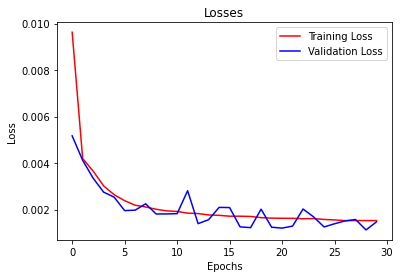

The Mean Squared Error is: 0.7158842079850078


In [22]:
## Saving the result file to the folder of the model

dest = os.getcwd()
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = simple_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

simple_lstm.load_weights(filepath_simple)
preds = simple_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [23]:
## Attention model
K.clear_session()
atten_lstm = keras.Sequential()
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Flatten())
atten_lstm.add(keras.layers.Dense(512, activation='relu'))
atten_lstm.add(keras.layers.Dense(128, activation='relu'))
atten_lstm.add(keras.layers.Dense(64, activation='relu'))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.Dense(32))
atten_lstm.add(keras.layers.Dense(6))

atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/30
897/897 [==============================] - 9s 10ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0012 - val_mae: 0.0254
Epoch 2/30
897/897 [==============================] - 8s 9ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0012 - val_mae: 0.0251
Epoch 3/30
897/897 [==============================] - 8s 9ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0014 - val_mae: 0.0280
Epoch 4/30
897/897 [==============================] - 8s 9ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.0012 - val_mae: 0.0248
Epoch 5/30
897/897 [==============================] - 8s 9ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0013 - val_mae: 0.0248
Epoch 6/30
897/897 [==============================] - 8s 9ms/step - loss: 0.0014 - mae: 0.0275 - val_loss: 0.0017 - val_mae: 0.0299
Epoch 7/30
897/897 [==============================] - 8s 9ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 0.0012 - val_mae: 0.0230
Epoch 8/30
897/897 [==

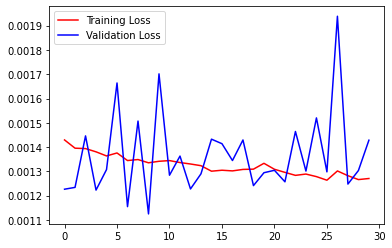

The Mean Squared Error is: 0.5250971391034144


In [26]:
# Problem: different result

## Saving the result file to the folder of the model

#dest = ''

dest = os.getcwd()
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')


history = atten_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_lstm.load_weights(filepath_attention)
preds = atten_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))   

wk.save(f'LSTM Result.xls')

## CNN-LSTM

In [27]:
## Creating the prelimaries 

filepath_simple = 'simple_cnnlstm.hdf5'
filepath_attention = 'attention_cnnlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [28]:
## Simple CNN-LSTM model
K.clear_session()
simple_cnnlstm = keras.Sequential()
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.Flatten())
simple_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(32))
simple_cnnlstm.add(keras.layers.Dense(6))

simple_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/30
897/897 [==============================] - 10s 6ms/step - loss: 0.0050 - mae: 0.0445 - val_loss: 0.0023 - val_mae: 0.0348
Epoch 2/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0027 - val_mae: 0.0369
Epoch 3/30
897/897 [==============================] - 5s 5ms/step - loss: 0.0014 - mae: 0.0272 - val_loss: 0.0018 - val_mae: 0.0319
Epoch 4/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 0.0025 - val_mae: 0.0370
Epoch 5/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 0.0017 - val_mae: 0.0291
Epoch 6/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 7/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0011 - mae: 0.0234 - val_loss: 0.0018 - val_mae: 0.0309
Epoch 8/30
897/897 [==

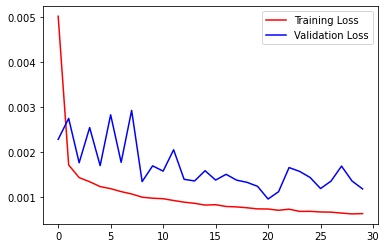

The Mean Squared Error is: 0.7402914763975861


In [29]:
# Problem different results

## Saving the result file to the folder of the model

try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

history = simple_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_cnnlstm.load_weights(filepath_simple)
preds = simple_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [30]:
## Attention model
K.clear_session()
atten_cnnlstm = keras.Sequential()
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(attention(return_sequences=True))
atten_cnnlstm.add(keras.layers.Flatten())
atten_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(32))
atten_cnnlstm.add(keras.layers.Dense(6))

atten_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Directory present
Epoch 1/30
897/897 [==============================] - 8s 6ms/step - loss: 0.0064 - mae: 0.0503 - val_loss: 0.0034 - val_mae: 0.0425
Epoch 2/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0028 - val_mae: 0.0372
Epoch 3/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 4/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0014 - mae: 0.0265 - val_loss: 0.0023 - val_mae: 0.0350
Epoch 5/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 0.0015 - val_mae: 0.0275
Epoch 6/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0033 - val_mae: 0.0485
Epoch 7/30
897/897 [==============================] - 5s 6ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 0.0019 - val_mae: 0.0336
Epoch 8/30
897/897 [==============================] - 6s 6

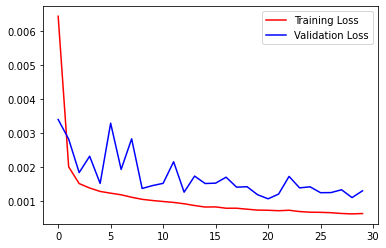

The Mean Squared Error is: 1.0157186975414931


In [31]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

history = atten_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_cnnlstm.load_weights(filepath_attention)
preds = atten_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)


e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)

        sheet3.write(0,i,"Real-test")
        sheet4.write(0,i,"Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                sheet3.write(j+1,i,float(y_test_unscaled[j,i]))
        for k in range(y_pred_unscaled.shape[0]):
                sheet4.write(k+1,i,float(y_pred_unscaled[k,i]))
            
wk.save('CNN-LStM Results.xls')


## ConvLSTM Model

In [32]:
## Creating the prelimaries 

filepath_simple = 'simple_convlstm.hdf5'
filepath_attention = 'attention_convlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)


In [33]:
## Reshaping the training and testing data to suit the convlstm model
x_train_conv =x_train.reshape(x_train.shape[0], 1, 1, x_train.shape[1], x_train.shape[2])
x_test_conv = x_test.reshape(x_test.shape[0], 1, 1, x_test.shape[1], x_test.shape[2])

In [34]:
## Simple ConvLSTM model
K.clear_session()
simple_convlstm = keras.Sequential()
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.Flatten())
simple_convlstm.add(keras.layers.Dense(512, activation='relu'))
simple_convlstm.add(keras.layers.Dense(128, activation='relu'))
simple_convlstm.add(keras.layers.Dense(64, activation='relu'))
simple_convlstm.add(keras.layers.Dense(32))
simple_convlstm.add(keras.layers.Dense(6))

simple_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/30
897/897 [==============================] - 36s 34ms/step - loss: 0.0081 - mae: 0.0559 - val_loss: 0.0045 - val_mae: 0.0512
Epoch 2/30
897/897 [==============================] - 31s 34ms/step - loss: 0.0020 - mae: 0.0324 - val_loss: 0.0027 - val_mae: 0.0351
Epoch 3/30
897/897 [==============================] - 30s 33ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0019 - val_mae: 0.0306
Epoch 4/30
897/897 [==============================] - 30s 33ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0016 - val_mae: 0.0271
Epoch 5/30
897/897 [==============================] - 29s 32ms/step - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0018 - val_mae: 0.0300
Epoch 6/30
897/897 [==============================] - 29s 32ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 0.0020 - val_mae: 0.0334
Epoch 7/30
897/897 [==============================] - 29s 32ms/step - loss: 0.0012 - mae: 0.0235 - val_loss: 0.0018 - val_mae: 0.0311
Epoch 8/3

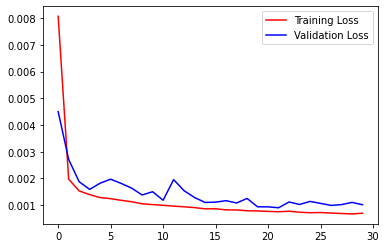

The Mean Squared Error is: 0.5600711645993203


In [35]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = simple_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_convlstm.load_weights(filepath_simple)
preds = simple_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [36]:
## Attention model
K.clear_session()
atten_convlstm = keras.Sequential()
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(attention(return_sequences=True))
atten_convlstm.add(keras.layers.Flatten())
atten_convlstm.add(keras.layers.Dense(512, activation='relu'))
atten_convlstm.add(keras.layers.Dense(128, activation='relu'))
atten_convlstm.add(keras.layers.Dense(64, activation='relu'))
atten_convlstm.add(keras.layers.Dense(32))
atten_convlstm.add(keras.layers.Dense(6))

atten_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])

Directory present
Epoch 1/30
897/897 [==============================] - 38s 36ms/step - loss: 0.0089 - mae: 0.0573 - val_loss: 0.0049 - val_mae: 0.0538
Epoch 2/30
897/897 [==============================] - 30s 34ms/step - loss: 0.0022 - mae: 0.0342 - val_loss: 0.0027 - val_mae: 0.0356
Epoch 3/30
897/897 [==============================] - 31s 35ms/step - loss: 0.0016 - mae: 0.0283 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 4/30
897/897 [==============================] - 30s 34ms/step - loss: 0.0015 - mae: 0.0268 - val_loss: 0.0019 - val_mae: 0.0297
Epoch 5/30
897/897 [==============================] - 31s 34ms/step - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0023 - val_mae: 0.0337
Epoch 6/30
897/897 [==============================] - 31s 34ms/step - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0024 - val_mae: 0.0384
Epoch 7/30
897/897 [==============================] - 30s 34ms/step - loss: 0.0012 - mae: 0.0240 - val_loss: 0.0021 - val_mae: 0.0347
Epoch 8/30
897/897 [========================

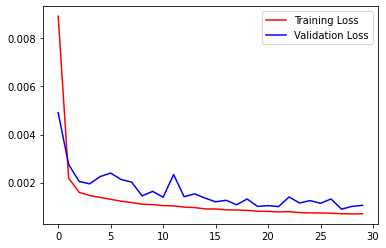

The Mean Squared Error is: 0.6909091520005658


In [37]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = atten_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_convlstm.load_weights(filepath_attention)
preds = atten_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))
wk.save('ConvLSTM Results.xls')

## Seq2Seq Model

In [38]:
## Creating the prelimaries 

filepath_simple = 'simple_seq2seq.hdf5'
filepath_attention = 'attention_seq2seq.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [39]:
## Reshaping the training data to suit Seq2Seq model
y_train_seq = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [40]:
## Simple Model
K.clear_session()
input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

### --------------------------------Encoder Section -----------------------------------------------###
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=False, return_state=True)(encoder_third)

###---------------------------------Decorder Section-----------------------------------------------###
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first,initial_state=[encoder_fourth,encoder_fourth_s2])
decoder_third = keras.layers.LSTM(128,return_sequences=True)(decoder_second)
decoder_fourth = keras.layers.LSTM(128,return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128,return_sequences=True)(decoder_fourth)
print(decoder_fifth)

###--------------------------------Output Section-------------------------------------------------###
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_fifth)

simple_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=LR)
simple_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
simple_seq.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 128), dtype=tf.float32, name=None), name='lstm_7/PartitionedCall:1', description="created by layer 'lstm_7'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 14)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       73216       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (N

Creating a new directory......
New Directory Created
Epoch 1/30
897/897 [==============================] - 21s 17ms/step - loss: 0.0108 - mae: 0.0637 - val_loss: 0.0048 - val_mae: 0.0529
Epoch 2/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0033 - mae: 0.0427 - val_loss: 0.0038 - val_mae: 0.0495
Epoch 3/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0024 - mae: 0.0359 - val_loss: 0.0023 - val_mae: 0.0350
Epoch 4/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0016 - mae: 0.0287 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 5/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0013 - mae: 0.0257 - val_loss: 0.0021 - val_mae: 0.0349
Epoch 6/30
897/897 [==============================] - 14s 15ms/step - loss: 0.0012 - mae: 0.0245 - val_loss: 0.0016 - val_mae: 0.0286
Epoch 7/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 0.0018 - val_mae: 0.0309
Epoch 8/3

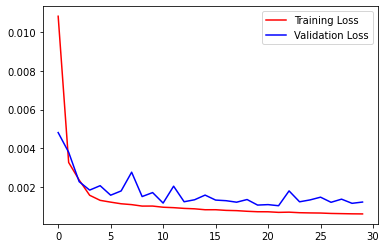

(7957, 6)
The Mean Squared Error is: 0.6377805722421384


In [41]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = simple_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_seq.load_weights(filepath_simple)
preds = simple_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [42]:
## Attention Model
K.clear_session()

input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

###----------------------------------------Encoder Section------------------------------------------###
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=True,return_state=True)(encoder_third)

###-----------------------------------------Decoder Section------------------------------------------###
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth_s1)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first, initial_state=[encoder_fourth_s1, encoder_fourth_s2])

attention = keras.layers.dot([decoder_second, encoder_fourth], axes=[2, 2])
attention = keras.layers.Activation('softmax')(attention)
context = keras.layers.dot([attention, encoder_fourth], axes=[2, 1])

decoder_third = keras.layers.concatenate([context, decoder_second])

decoder_fourth = keras.layers.LSTM(128, return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128, return_sequences=True)(decoder_fourth)
decoder_sixth = keras.layers.LSTM(128, return_sequences=True)(decoder_fifth)

###-----------------------------------------Output Section-----------------------------------------###
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_sixth)

atten_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=LR)
atten_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
atten_seq.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 14)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       73216       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6, 128)       131584      lstm_1[0][0]                     
______________________________________________________________________________________________

Directory present
Epoch 1/30
897/897 [==============================] - 22s 17ms/step - loss: 0.0093 - mae: 0.0606 - val_loss: 0.0051 - val_mae: 0.0540
Epoch 2/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0034 - mae: 0.0433 - val_loss: 0.0039 - val_mae: 0.0499
Epoch 3/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0025 - mae: 0.0367 - val_loss: 0.0022 - val_mae: 0.0358
Epoch 4/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0016 - mae: 0.0287 - val_loss: 0.0021 - val_mae: 0.0349
Epoch 5/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0018 - val_mae: 0.0314
Epoch 6/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0017 - val_mae: 0.0297
Epoch 7/30
897/897 [==============================] - 13s 15ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0017 - val_mae: 0.0286
Epoch 8/30
897/897 [========================

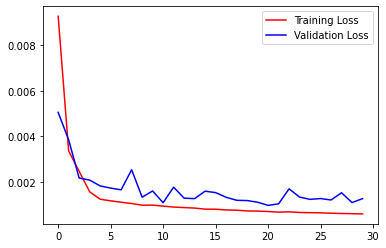

(7957, 6)
The Mean Squared Error is: 0.46563171313052426


In [43]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = atten_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_seq.load_weights(filepath_attention)
preds = atten_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))
wk.save('Seq2Seq Results.xls')

## Wavenet Model

In [44]:
## Creating the prelimaries 

filepath_simple = 'simple_wavenet.hdf5'
filepath_attention = 'attention_wavenet.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Real-test', cell_overwrite_ok=True)
sheet4 = wk.add_sheet('Predicted-test', cell_overwrite_ok=True)

In [45]:
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = keras.layers.Conv1D(64, 1, padding='same')(x) 
    x_f = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = keras.layers.Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(z)

    x = keras.layers.Add()([x, z])    

    skips.append(z)

out = keras.layers.Activation('relu')(keras.layers.Add()(skips)) 
out = keras.layers.Conv1D(128, 1, padding='same')(out)
out = keras.layers.Activation('relu')(out)
out = keras.layers.Dropout(0.4)(out)
out = keras.layers.Conv1D(1, 1, padding='same')(out)

out = keras.layers.Flatten()(out)
out = keras.layers.Dense(6)(out)

simple_wavenet = keras.Model(inputs, out)

simple_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])


Creating a new directory......
New Directory Created
Epoch 1/30
897/897 [==============================] - 17s 17ms/step - loss: 0.0191 - mae: 0.0904 - val_loss: 0.0053 - val_mae: 0.0518
Epoch 2/30
  5/897 [..............................] - ETA: 13s - loss: 0.0049 - mae: 0.0542

C:\Users\WSF_CA_2021\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


897/897 [==============================] - 14s 16ms/step - loss: 0.0043 - mae: 0.0500 - val_loss: 0.0030 - val_mae: 0.0413
Epoch 3/30
897/897 [==============================] - 14s 15ms/step - loss: 0.0029 - mae: 0.0407 - val_loss: 0.0029 - val_mae: 0.0404
Epoch 4/30
897/897 [==============================] - 14s 16ms/step - loss: 0.0022 - mae: 0.0353 - val_loss: 0.0026 - val_mae: 0.0412
Epoch 5/30
897/897 [==============================] - 14s 15ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0025 - val_mae: 0.0386
Epoch 6/30
897/897 [==============================] - 14s 15ms/step - loss: 0.0016 - mae: 0.0299 - val_loss: 0.0020 - val_mae: 0.0334
Epoch 7/30
897/897 [==============================] - 14s 15ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0017 - val_mae: 0.0310
Epoch 8/30
897/897 [==============================] - 14s 15ms/step - loss: 0.0014 - mae: 0.0272 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 9/30
897/897 [==============================] - 14s 15ms/step - los

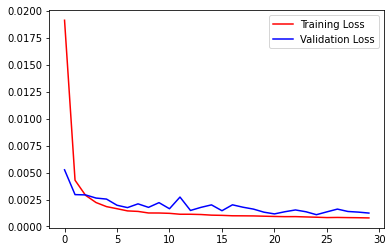

(7957, 6)
The Mean Squared Error is: 0.9392224403394313


In [46]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Wavenet'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Wavenet')
    os.chdir(os.path.join(dest,'Wavenet'))
    print('New Directory Created')

history = simple_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_wavenet.load_weights(filepath_simple)
preds = simple_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [47]:
## Attention model
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = Conv1D(64, 1, padding='same')(x) 
    x_f = Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = Conv1D(64, 1, padding='same', activation='relu')(z)

    x = Add()([x, z])    

    skips.append(z)

out = Activation('relu')(keras.layers.Add()(skips)) 
#out = attention(return_sequences=True)(out)
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(0.4)(out)
out = Conv1D(1, 1, padding='same')(out)
#out = attention(return_sequences=True)(out)
out = Flatten()(out)
out = Dense(6)(out)

atten_wavenet = keras.Model(inputs, out)

atten_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=['mae'])
atten_wavenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6, 14)]      0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 6, 64)        960         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 6, 128)       16512       conv1d_30[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 6, 128)       16512       conv1d_30[0][0]                  
____________________________________________________________________________________________

Directory present
Epoch 1/30
897/897 [==============================] - 17s 17ms/step - loss: 0.0225 - mae: 0.0999 - val_loss: 0.0047 - val_mae: 0.0526
Epoch 2/30
  7/897 [..............................] - ETA: 15s - loss: 0.0055 - mae: 0.0581

C:\Users\WSF_CA_2021\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


897/897 [==============================] - 15s 17ms/step - loss: 0.0052 - mae: 0.0556 - val_loss: 0.0036 - val_mae: 0.0473
Epoch 3/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0036 - mae: 0.0455 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 4/30
897/897 [==============================] - 14s 16ms/step - loss: 0.0028 - mae: 0.0400 - val_loss: 0.0035 - val_mae: 0.0466
Epoch 5/30
897/897 [==============================] - 15s 16ms/step - loss: 0.0023 - mae: 0.0356 - val_loss: 0.0035 - val_mae: 0.0469
Epoch 6/30
897/897 [==============================] - 15s 16ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0019 - val_mae: 0.0334
Epoch 7/30
897/897 [==============================] - 15s 16ms/step - loss: 0.0015 - mae: 0.0288 - val_loss: 0.0016 - val_mae: 0.0294
Epoch 8/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 0.0024 - val_mae: 0.0385
Epoch 9/30
897/897 [==============================] - 14s 16ms/step - los

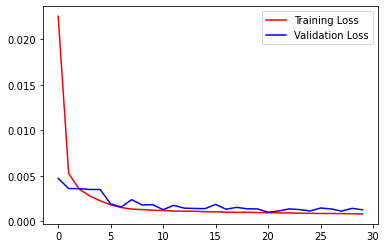

(7957, 6)
The Mean Squared Error is: 1.1512950765566685


In [48]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Wavenet'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Wavenet')
    os.chdir(os.path.join(dest,'Wavenet'))
    print('New Directory Created')

history = atten_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_wavenet.load_weights(filepath_attention)
preds = atten_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
        sheet3.write(0, i, "Real-test")
        sheet4.write(0, i, "Predicted_test")
        for j in range(y_test_unscaled.shape[0]):
                 sheet3.write(j + 1, i, float(y_test_unscaled[j, i]))
        for k in range(y_pred_unscaled.shape[0]):
                 sheet4.write(k + 1, i, float(y_pred_unscaled[k, i]))
wk.save('Wavenet Results.xls')